# Analysis of J Dilla's Samples

By Anoop Patta

## Introduction

James Dewitt Yancey, better known by his stage name J Dilla, is undeniably the greatest American record producer. He emerged from the mid-1990s underground hip-hop scene in Detroit, Michigan. Throughout his career, J Dilla produced for and worked with some of the most significant names in the music industry, including A Tribe Called Quest, De La Soul, The Pharcyde, Erykah Badu, and many more.

Sampling, a key element in J Dilla's music, is a method used in music production where a portion of a sound recording is reused as an instrument or a sound recording in a different song or piece. This technique, while not exclusive to any genre, is predominantly used in hip-hop and electronic music. Sampling can involve any sound or piece of music, but it often includes snippets of other songs, such as drum breaks, basslines, or melodies, that are looped and rearranged to create new compositions.

J Dilla was a master of this craft, renowned for his unique and innovative approach to sampling. Spending hours on the floors of record stores, he possessed an uncanny ability and persistance to uncover hidden gems in obscure records. The term 'crate digging' encapsulates this practice of rummaging through crates at music stores or garage sales, in a quest to discover rare or forgotten music. This meticulous search for the perfect sample was the crux of J Dilla's creative process.

In this tutorial, we will analyze all documented samples that J Dilla has used during his career. We will specifically explore the relationships and importance of several audio features for each sample.

To achieve this, we will employ various techniques including data cleaning and processing. Through this process, we will uncover important audio features that impact the overall quality and popularity of songs.

To gain a deeper understanding of the data, we will employ visualization techniques such as pie charts, scatter plots, bar graphs, and heatmaps. These visualizations will allow us to identify correlations and patterns between different audio attributes.

In addition to analysis and visualization, we will utilize machine learning algorithms to make predictions based on the data. Specifically, we will employ the RandomForest model, a powerful algorithm for classification and regression tasks. By training the model with the music data, we will be able to predict important audio features that contribute to the success and appeal of songs.

Furthermore, we will employ hierarchical clustering techniques to group similar songs together based on their audio features. This will help us identify distinct clusters within the music dataset and gain insights into the relationships of different genres.

In [145]:
# imports
import requests
import os
import pandas as pd
from bs4 import BeautifulSoup
import re
import base64
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

To run this locally, create a .env file and add CLIENT_ID and CLIENT_SECRET credentials from https://developer.spotify.com/.

In [2]:
# Load the Spotify variables Client ID and Client Secret from the .env file
load_dotenv()

client_id = os.environ.get("CLIENT_ID")
client_secret = os.environ.get("CLIENT_SECRET")

## Data Collection + Cleaning

I tried multiple ways to scrape the data from whosampled.com, however, I ran into the following issues. 

- It is a dynamic website, so I cannot use BeautifulSoup. 
- There are no public-facing fetch API's called, so I cannot directly get the data.
- WhoSampled uses CloudFlare so I cannot use a client like Selenium to simulate navigating the page and downloading it.

In my despair, I decided to employ a fearless idea - manually scrape the html files myself.

All raw html files are located in the raw folder.

Loading in data from https://www.whosampled.com/J-Dilla/samples/ stored in raw/whosampled. I used regex to clean the raw string and match the song_name, artists, and year. I stored these values in the dillaSamples dataframe.

In [3]:
dillaSamples = pd.DataFrame(columns=['song_name', 'artists', 'year'])  # Creating an empty DataFrame

# loop through the html files
for i in range(1, 89):
    filename = f"raw/whosampled/{i}.html"
    with open(filename, 'r') as f:
        # scrape using BeautifulSoup
        content = f.read()
        soup = BeautifulSoup(content, "html.parser")
        track_connections = soup.find_all('div', class_='track-connection')

        # Clean the text using regex to match out column names
        pattern = r"\n\n(.+)\nby ([^(\n]+)(?: feat\. ([^(\n]+))?(?: \((\d{4})\))?\n\n"
        for track in track_connections:
            match = re.search(pattern, track.text)
            if match:
                song_name = match.group(1)
                artists = match.group(2)
                year = match.group(4)
                                  
                dillaSamples = pd.concat([dillaSamples, pd.DataFrame({'song_name': song_name, 'artists': artists, 'year': year}, index=[0])],
                                         ignore_index=True)

print(dillaSamples)

                             song_name                   artists  year
0                 Saudade Vem Correndo  Stan Getz and Luiz Bonfá  1963
1             Diana in the Autumn Wind              Gap Mangione  1968
2                          Dreamflower               Tarika Blue  1976
3                       Open Your Eyes            Bobby Caldwell  1980
4             All I Do Is Think of You             The Jackson 5  1975
..                                 ...                       ...   ...
863                            Love It                     Bilal  2000
864                      The New Style              Beastie Boys  1986
865                         Let's Ride                     Q-Tip  1999
866                        North Beach               George Duke  1973
867  The Jungle Pioneer (Viola Violar)    The Manhattan Transfer  1987

[868 rows x 3 columns]


Loading in data from https://rateyourmusic.com/list/mrdr7/j_dilla_samples/. I had the same issue with RateYourMusic, so I manually scraped the html, but luckily there wasn't many pages. I used regex as before to match the song_name, artists, and year. I also cleaned some of the text by removing links in some of the values. I saved all values in the dillaSamples dataframe as well.

In [4]:
# loop through the html files
for i in range(1, 7):
    filename = f"raw/rateyourmusic/{i}.html"
    with open(filename, 'r') as f:
        # scrape using BeautifulSoup
        content = f.read()
        soup = BeautifulSoup(content, "html.parser")
        entries = soup.find_all('td', class_='main_entry')
        
        # extract the desired artists, year, and song_name
        for entry in entries:
            artist = None
            year = None
            song_name = None
            
            if entry.find('a', class_='list_artist') is not None:
                artists = entry.find('a', class_='list_artist').text.strip()
            if entry.find('span', class_='rel_date') is not None:
                year = re.search(r'\((\d{4})\)', entry.find('span', class_='rel_date').text).group(1)
            song_name_element = entry.find('span', class_='rendered_text')
            if song_name_element is not None:
                song_name = song_name_element.text.strip()
                # remove links from song_name
                song_name = re.sub(r'http\S+', '', song_name).strip()
                
            dillaSamples = pd.concat([dillaSamples, pd.DataFrame({'song_name': song_name, 'artists': artists, 'year': year}, index=[0])],
                                         ignore_index=True)

print(dillaSamples)

                     song_name                   artists  year
0         Saudade Vem Correndo  Stan Getz and Luiz Bonfá  1963
1     Diana in the Autumn Wind              Gap Mangione  1968
2                  Dreamflower               Tarika Blue  1976
3               Open Your Eyes            Bobby Caldwell  1980
4     All I Do Is Think of You             The Jackson 5  1975
...                        ...                       ...   ...
1143                Lonely Man              Johnny Adams  1969
1144  Oh No I Don't Believe It     The Fraternity of Man  1968
1145   Shine On Straight Arrow           Cris Williamson  1971
1146                Tight Rope   Walter "Junie" Morrison  1975
1147                     Sugar       Rahsaan Roland Kirk  1977

[1148 rows x 3 columns]


Dropping all samples that came out after Dilla's death (2006).

In [5]:
dillaSamples['year'] = pd.to_numeric(dillaSamples['year'], errors='coerce')
dillaSamples = dillaSamples[dillaSamples['year'] <= 2006]

At this point, we need to remove all duplicates in the list. This would be difficult to do using even a good search library as duplicate songs song_name may refer to the same song but have a different value for song_name. We need a robust way to classify each song correctly based on the song_name and artists. To do this, we can use Spotify search to find each songs Spotify ID and remove songs with duplicate ID's by searching with the song_name and artists.

Getting Spotify Auth Token...

If you would like to run this code block, visit https://developer.spotify.com and create an application to get your client_id and client_secret keys. Then load in the env variables in the code block above.

In [6]:
auth_url = 'https://accounts.spotify.com/api/token'

auth_headers = {
    'Authorization': 'Basic ' + base64.b64encode((client_id + ':' + client_secret).encode('ascii')).decode('ascii')
}

auth_data = {
    'grant_type': 'client_credentials'
}

response = requests.post(auth_url, headers=auth_headers, data=auth_data)
auth_token = response.json()['access_token']
# Set the authorization token in header
headers = {'Authorization': f'Bearer {auth_token}'}

Getting Spotify ID's for each song using https://api.spotify.com/v1/search endpoint and song_name and artists as search query parameters...

In [7]:
# Iterate through each row in the dillaSamples dataframe
for index, row in dillaSamples.iterrows():
    # Set the query parameters
    song_name = row['song_name']
    artist_name = row['artists']
    query_params = {
        'q': f'remaster%2520track:{song_name}%20artist:{artist_name}',
        'type': 'track',
        'limit': 1
    }
    
    # Make Spotify Developer API request
    response = requests.get('https://api.spotify.com/v1/search', params=query_params, headers=headers)
    # Process the response
    if response.status_code == 200:
        response_json = response.json()
        tracks = response_json['tracks']['items']
        if tracks:
            # Only set the spotify_id for the current row being processed
            dillaSamples.loc[index, 'spotify_id'] = tracks[0]["id"]
        else:
            dillaSamples.loc[index, 'spotify_id'] = "None"
    else:
        dillaSamples.loc[index, 'spotify_id'] = "None"
        print(f'Error for {song_name} - {artist_name}: {response.status_code} - {response.text}')

dillaSamples

,song_name,artists,year,spotify_id
0,Saudade Vem Correndo,Stan Getz and Luiz Bonfá,1963.0,3QxAadrRx8aSEVd6Qzr8KF
1,Diana in the Autumn Wind,Gap Mangione,1968.0,2yONEvu95BwhLRS3oSyBsB
2,Dreamflower,Tarika Blue,1976.0,4iyH37AHAkYK1MVhveeqcm
3,Open Your Eyes,Bobby Caldwell,1980.0,5TA4he79xD3fpvy0sidiOV
4,All I Do Is Think of You,The Jackson 5,1975.0,5GoheMjTcV8xbbUUWchvjl
...,...,...,...,...
1143,Lonely Man,Johnny Adams,1969.0,2NkY19YwDttHE4K5xM6mwp
1144,Oh No I Don't Believe It,The Fraternity of Man,1968.0,0U2TocFjqul3sis3sE5jZl
1145,Shine On Straight Arrow,Cris Williamson,1971.0,1Ttf7o5eQj9kepWRZpo8nG
1146,Tight Rope,"Walter ""Junie"" Morrison",1975.0,2Z3EEql0jVgA5jehoWYT7P


Removing duplicates in dataframe based on spotify_id for clean dataset.

In [8]:
dillaSamples = dillaSamples.drop_duplicates(subset='spotify_id', keep='first')

Getting audio features for every song from Spotify API endpoint https://api.spotify.com/v1/audio-features/. 

Explanation of all audio features below.

In [9]:
# Iterate through each row in the dillaSamples dataframe
for index, row in dillaSamples.iterrows(): 
    # Make Spotify Developer API request to get the audio features for the current song
    spotify_id = row['spotify_id']
    if spotify_id:
        response = requests.get(f'https://api.spotify.com/v1/audio-features/{spotify_id}', headers=headers)
        # Process the response to get the audio features
        if response.status_code == 200:
            response_json = response.json()
            dillaSamples.loc[index, 'acousticness'] = response_json["acousticness"]
            dillaSamples.loc[index, 'danceability'] = response_json["danceability"]
            dillaSamples.loc[index, 'energy'] = response_json["energy"]
            dillaSamples.loc[index, 'instrumentalness'] = response_json["instrumentalness"]
            dillaSamples.loc[index, 'key'] = response_json["key"]
            dillaSamples.loc[index, 'liveness'] = response_json["liveness"]
            dillaSamples.loc[index, 'loudness'] = response_json["loudness"]
            dillaSamples.loc[index, 'mode'] = response_json["mode"]
            dillaSamples.loc[index, 'speechiness'] = response_json["speechiness"]
            dillaSamples.loc[index, 'tempo'] = response_json["tempo"]
            dillaSamples.loc[index, 'time_signature'] = response_json["time_signature"]
            dillaSamples.loc[index, 'valence'] = response_json["valence"]
        else:
            print(f'Error for {song_name} - {artist_name}: {response.status_code} - {response.text}')
    else:
        print(f'Skipping {song_name} - {artist_name} as no Spotify ID found')
    
dillaSamples

/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_6705/3725888666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'acousticness'] = response_json["acousticness"]
/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_6705/3725888666.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'danceability'] = response_json["danceability"]
/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_6705/3725888666.py:12: SettingWithCopyWarning: 
A val

Error for Sugar - Rahsaan Roland Kirk: 400 - {
  "error" : {
    "status" : 400,
    "message" : "invalid request"
  }
}


,song_name,artists,year,spotify_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Saudade Vem Correndo,Stan Getz and Luiz Bonfá,1963.0,3QxAadrRx8aSEVd6Qzr8KF,0.946,0.634,0.2880,0.163000,4.0,0.3660,-16.798,1.0,0.0377,90.633,4.0,0.671
1,Diana in the Autumn Wind,Gap Mangione,1968.0,2yONEvu95BwhLRS3oSyBsB,0.661,0.525,0.4170,0.006670,7.0,0.1370,-10.423,0.0,0.0291,100.789,4.0,0.291
2,Dreamflower,Tarika Blue,1976.0,4iyH37AHAkYK1MVhveeqcm,0.770,0.551,0.2520,0.719000,3.0,0.0834,-17.767,0.0,0.0293,134.878,4.0,0.376
3,Open Your Eyes,Bobby Caldwell,1980.0,5TA4he79xD3fpvy0sidiOV,0.889,0.735,0.2870,0.001240,2.0,0.0776,-17.593,1.0,0.0465,95.539,4.0,0.409
4,All I Do Is Think of You,The Jackson 5,1975.0,5GoheMjTcV8xbbUUWchvjl,0.571,0.545,0.6420,0.000003,8.0,0.0881,-6.535,0.0,0.0379,121.654,4.0,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,Ocapella,Ringo Starr,1974.0,1hxbW2aQxmFSChaFeOeD5K,0.084,0.753,0.2440,0.000003,10.0,0.0607,-19.395,1.0,0.2530,83.703,4.0,0.928
1137,Equipoise,Stanley Cowell,1974.0,0fZQHYizQZ3aj5xfNMi4BI,0.826,0.509,0.3640,0.897000,11.0,0.1190,-15.547,0.0,0.0405,140.285,4.0,0.371
1139,Nothing's the Same,Banco,1975.0,3vSLSOhE8HWBC2WiN0j0hD,0.492,0.736,0.3080,0.002480,11.0,0.1790,-11.543,1.0,0.0421,132.767,4.0,0.439
1146,Tight Rope,"Walter ""Junie"" Morrison",1975.0,2Z3EEql0jVgA5jehoWYT7P,0.122,0.783,0.7020,0.000039,2.0,0.0501,-10.215,0.0,0.0517,103.665,4.0,0.949


Getting popularity of each song on Spotify (0-1) from Spotify endpoint https://api.spotify.com/v1/tracks/ (stored in song_popularity). Also getting the artist_id so I can later call the Spotify API artists endpoint to get genres for every track. For some reason this tracks endpoint is supposed to return genres but it does not. 

In [10]:
for index, row in dillaSamples.iterrows():
    # Make Spotify Developer API request to get the audio features for the current song
    spotify_id = row['spotify_id']
    if spotify_id:
        response = requests.get(f'https://api.spotify.com/v1/tracks/{spotify_id}', headers=headers)
        if response.status_code == 200:
            response_json = response.json()
            song_popularity = response_json.get("popularity")
            dillaSamples.loc[index, 'song_popularity'] = song_popularity
            artist_id = response_json.get("artists")[0]["id"]
            dillaSamples.loc[index, 'artist_id'] = artist_id
        else:
            error_msg = f'Error for {row["song_name"]} - {row["artists"]}: {response.status_code} - {response.text}'
    else:
        print(f'Skipping {row["song_name"]} - {row["artists"]} as no Spotify ID found')

dillaSamples

/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_6705/1515006351.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'song_popularity'] = song_popularity
/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_6705/1515006351.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'artist_id'] = artist_id


,song_name,artists,year,spotify_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_popularity,artist_id
0,Saudade Vem Correndo,Stan Getz and Luiz Bonfá,1963.0,3QxAadrRx8aSEVd6Qzr8KF,0.946,0.634,0.2880,0.163000,4.0,0.3660,-16.798,1.0,0.0377,90.633,4.0,0.671,54.0,0FMucZsEnCxs5pqBjHjIc8
1,Diana in the Autumn Wind,Gap Mangione,1968.0,2yONEvu95BwhLRS3oSyBsB,0.661,0.525,0.4170,0.006670,7.0,0.1370,-10.423,0.0,0.0291,100.789,4.0,0.291,14.0,0mQU7aLi35kTXGf2WjKM35
2,Dreamflower,Tarika Blue,1976.0,4iyH37AHAkYK1MVhveeqcm,0.770,0.551,0.2520,0.719000,3.0,0.0834,-17.767,0.0,0.0293,134.878,4.0,0.376,47.0,5lq6V5V6D0zzfClxSPzV4G
3,Open Your Eyes,Bobby Caldwell,1980.0,5TA4he79xD3fpvy0sidiOV,0.889,0.735,0.2870,0.001240,2.0,0.0776,-17.593,1.0,0.0465,95.539,4.0,0.409,55.0,4V4Z3qMCwYofWHtip6ePF6
4,All I Do Is Think of You,The Jackson 5,1975.0,5GoheMjTcV8xbbUUWchvjl,0.571,0.545,0.6420,0.000003,8.0,0.0881,-6.535,0.0,0.0379,121.654,4.0,0.511,52.0,2iE18Oxc8YSumAU232n4rW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,Ocapella,Ringo Starr,1974.0,1hxbW2aQxmFSChaFeOeD5K,0.084,0.753,0.2440,0.000003,10.0,0.0607,-19.395,1.0,0.2530,83.703,4.0,0.928,34.0,6DbJi8AcN5ANdtvJcwBSw8
1137,Equipoise,Stanley Cowell,1974.0,0fZQHYizQZ3aj5xfNMi4BI,0.826,0.509,0.3640,0.897000,11.0,0.1190,-15.547,0.0,0.0405,140.285,4.0,0.371,12.0,08t8fsEfRI7HSt2MlW2OTX
1139,Nothing's the Same,Banco,1975.0,3vSLSOhE8HWBC2WiN0j0hD,0.492,0.736,0.3080,0.002480,11.0,0.1790,-11.543,1.0,0.0421,132.767,4.0,0.439,54.0,6sFHvCyqklnJpXC9Nh1aag
1146,Tight Rope,"Walter ""Junie"" Morrison",1975.0,2Z3EEql0jVgA5jehoWYT7P,0.122,0.783,0.7020,0.000039,2.0,0.0501,-10.215,0.0,0.0517,103.665,4.0,0.949,17.0,3shcoEVk22LlHqZHyJtZWn


Getting genres of each song based on the genres the artist is associated with on Spotify from Spotify endpoint https://api.spotify.com/v1/artists/. As aforementioned, I would have wanted to get the genres associated with each song, but the Spotify API does not return genres information for tracks or their albums, but only for their artists.

In [13]:
for index, row in dillaSamples.iterrows():
    # Make Spotify Developer API request to get the audio features for the current song
    artist_id = row['artist_id']
    if spotify_id:
        response = requests.get(f'https://api.spotify.com/v1/artists/{artist_id}', headers=headers)
        if response.status_code == 200:
            response_json = response.json()
            genres = response_json.get("genres")
            genresStr = ','.join([str(elem) for elem in genres])
            dillaSamples.loc[index, 'genres'] = genresStr
        else:
            error_msg = f'Error for {row["song_name"]} - {row["artists"]}: {response.status_code} - {response.text}'
    else:
        print(f'Skipping {row["song_name"]} - {row["artists"]} as no Spotify ID found')

dillaSamples

/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_6705/3053981511.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dillaSamples.loc[index, 'genres'] = genresStr


,song_name,artists,year,spotify_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_popularity,artist_id,genres
0,Saudade Vem Correndo,Stan Getz and Luiz Bonfá,1963.0,3QxAadrRx8aSEVd6Qzr8KF,0.946,0.634,0.2880,0.163000,4.0,0.3660,-16.798,1.0,0.0377,90.633,4.0,0.671,54.0,0FMucZsEnCxs5pqBjHjIc8,"bebop,bossa nova,cool jazz,jazz,jazz saxophone..."
1,Diana in the Autumn Wind,Gap Mangione,1968.0,2yONEvu95BwhLRS3oSyBsB,0.661,0.525,0.4170,0.006670,7.0,0.1370,-10.423,0.0,0.0291,100.789,4.0,0.291,14.0,0mQU7aLi35kTXGf2WjKM35,
2,Dreamflower,Tarika Blue,1976.0,4iyH37AHAkYK1MVhveeqcm,0.770,0.551,0.2520,0.719000,3.0,0.0834,-17.767,0.0,0.0293,134.878,4.0,0.376,47.0,5lq6V5V6D0zzfClxSPzV4G,
3,Open Your Eyes,Bobby Caldwell,1980.0,5TA4he79xD3fpvy0sidiOV,0.889,0.735,0.2870,0.001240,2.0,0.0776,-17.593,1.0,0.0465,95.539,4.0,0.409,55.0,4V4Z3qMCwYofWHtip6ePF6,yacht rock
4,All I Do Is Think of You,The Jackson 5,1975.0,5GoheMjTcV8xbbUUWchvjl,0.571,0.545,0.6420,0.000003,8.0,0.0881,-6.535,0.0,0.0379,121.654,4.0,0.511,52.0,2iE18Oxc8YSumAU232n4rW,"motown,soul"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,Ocapella,Ringo Starr,1974.0,1hxbW2aQxmFSChaFeOeD5K,0.084,0.753,0.2440,0.000003,10.0,0.0607,-19.395,1.0,0.2530,83.703,4.0,0.928,34.0,6DbJi8AcN5ANdtvJcwBSw8,"beatlesque,classic rock,rock drums"
1137,Equipoise,Stanley Cowell,1974.0,0fZQHYizQZ3aj5xfNMi4BI,0.826,0.509,0.3640,0.897000,11.0,0.1190,-15.547,0.0,0.0405,140.285,4.0,0.371,12.0,08t8fsEfRI7HSt2MlW2OTX,spiritual jazz
1139,Nothing's the Same,Banco,1975.0,3vSLSOhE8HWBC2WiN0j0hD,0.492,0.736,0.3080,0.002480,11.0,0.1790,-11.543,1.0,0.0421,132.767,4.0,0.439,54.0,6sFHvCyqklnJpXC9Nh1aag,alt z
1146,Tight Rope,"Walter ""Junie"" Morrison",1975.0,2Z3EEql0jVgA5jehoWYT7P,0.122,0.783,0.7020,0.000039,2.0,0.0501,-10.215,0.0,0.0517,103.665,4.0,0.949,17.0,3shcoEVk22LlHqZHyJtZWn,p funk


In [12]:
print(dillaSamples.columns)

Index(['song_name', 'artists', 'year', 'spotify_id', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence',
       'song_popularity', 'artist_id'],
      dtype='object')


## dillaSamples Features Overview

Below are all columns in the dataframe that could be potential features based on the exploratory data analysis in the next section. Numerical measures such as acousticness and danceability are determined by Spotify based on a large model they have trained. We must determine the quality of the features below.

You can get more information here: https://developer.spotify.com/documentation/web-api/reference/get-track

- song_name: Name of song.

- artists: Artists featured on song.

- year: The year a song was released.

- spotify_id: Unique id for each song catalogued on Spotify.

- acousticness: A measure of how acoustic or non-electronic a song sounds. It ranges from 0.0 to 1.0, where 0.0 represents a song that is highly electronic and 1.0 represents a song that is purely acoustic.

- danceability: A measure of how suitable a song is for dancing based on its rhythm, tempo, and beat. It ranges from 0.0 to 1.0, where 0.0 represents a song that is not suitable for dancing and 1.0 represents a highly danceable song.

- energy: Represents the intensity and activity level of a song. It ranges from 0.0 to 1.0, where 0.0 represents a low-energy song and 1.0 represents a high-energy song.

- instrumentalness: Indicates the likelihood of a song being instrumental. It ranges from 0.0 to 1.0, where 0.0 represents a song that is likely to have vocals and 1.0 represents a song that is purely instrumental.

- key: Represents the key of the song. It is represented as an integer value that corresponds to different musical keys.

- liveness: Indicates the probability of a song being performed live. It ranges from 0.0 to 1.0, where 0.0 represents a studio-recorded song and 1.0 represents a song performed live.

- loudness: Represents the overall loudness of a song in decibels (dB). It is a negative value, where lower values indicate a softer song and higher values indicate a louder song.

- mode: Represents the modality (major or minor) of a song. It is represented as either 0 or 1, where 0 represents a minor key and 1 represents a major key.

- speechiness: Indicates the presence of spoken words in a song. It ranges from 0.0 to 1.0, where 0.0 represents a song with no speech and 1.0 represents a song that is entirely spoken word.

- tempo: Represents the tempo or speed of a song in beats per minute (BPM). It indicates how fast or slow a song is.

- time_signature: Represents the time signature of a song. It indicates the number of beats in each measure.

- valence: Represents the musical positiveness or negativity of a song. It ranges from 0.0 to 1.0, where 0.0 represents a sad or negative song and 1.0 represents a happy or positive song.

- song_popularity: Indicates the popularity of a song on Spotify. It is based on factors such as the number of streams and listener engagement.

- artist_id: A unique identifier for each artist catalogued on Spotify. It allows for distinguishing between different artists in the Spotify database.

- genres: Genres associated with the first artist in artists for each song.

Exporting to CSV for later experimentation...

In [15]:
dillaSamples.to_csv('dillaSamples.csv', index=False)

## Exploratory Data Analysis

There is a lot of features to explore, however, in order to assess the quality of the Spotify data, I will begin by looking at the distributions of most vectors listed above.

Distribution of Genres - I plotted the top 10 genres that Dilla sampled as a bar chart to see raw frequencies and as a pie chart to see the genres relative to the rest of the top 10. There are too many genres to plot everything which is why I stuck with the top 10.

In [102]:
dillaSamples = pd.read_csv('dillaSamples.csv')

# Convert 'genres' column to string type and replace 'nan' with ''
dillaSamples['genres'] = dillaSamples['genres'].astype(str).replace('nan', '')

dillaSamples = dillaSamples.dropna()

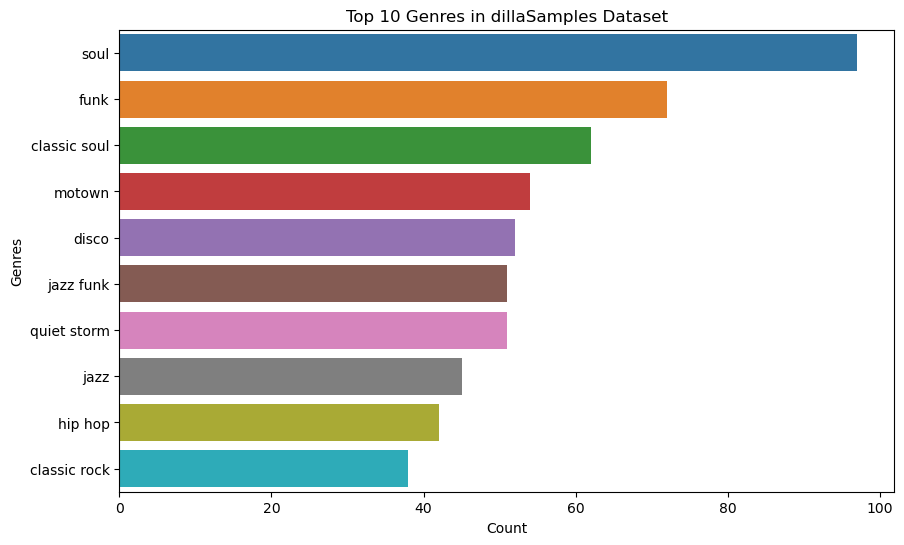

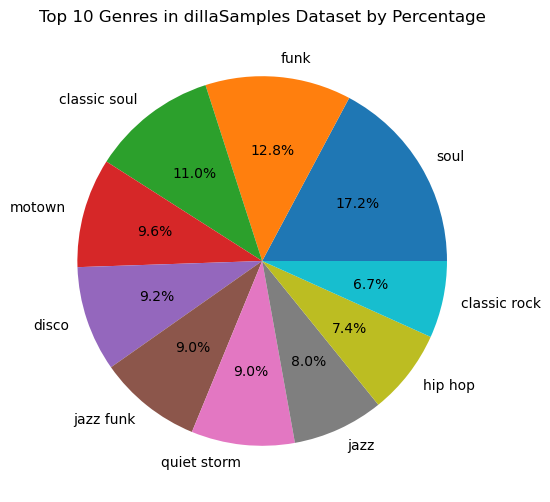

In [103]:
dillaSamples['genres'] = dillaSamples['genres'].str.split(',')
genres = dillaSamples.explode('genres')
genres = genres[genres['genres'].str.strip() != '']
genre_counts = genres['genres'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10,6))
sns.barplot(y=genre_counts.index[:10], x=genre_counts.values[:10], orient='h')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.title('Top 10 Genres in dillaSamples Dataset')
plt.show()

# Plot the pie chart
plt.figure(figsize=(10,6))
plt.pie(genre_counts[:10], labels=genre_counts.index[:10], autopct='%1.1f%%')
plt.title('Top 10 Genres in dillaSamples Dataset by Percentage')
plt.show()

An important observation to make here is that soul, funk, motown, hip-hop, and rock dominated most of Dilla's sample choice. This makes sense as it is well documented that Dilla most commonly sampled these genres.

Distribution of samples by year

Year min: 1949.0
Year max: 2006.0
Year mean: 1976.8287671232877
Year median: 1975.0


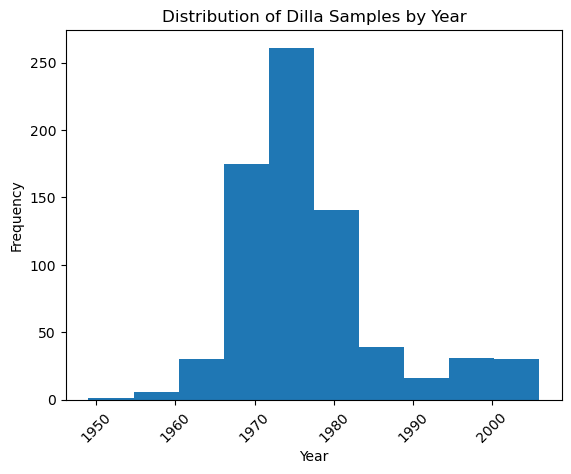

In [17]:
dillaSamples = dillaSamples.dropna(subset=['year'])

# Get the min and max of years
year_min = dillaSamples['year'].min()
year_max = dillaSamples['year'].max()
# Get the mean and median of the year column
year_mean = dillaSamples['year'].mean()
year_median = dillaSamples['year'].median()

print("Year min:", year_min)
print("Year max:", year_max)
print("Year mean:", year_mean)
print("Year median:", year_median)

# Create the histogram
plt.hist(dillaSamples['year'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Year')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

An important observation here is that the distribution is unimodal and symmetric around the mean which is 1976. This makes sense as this is when most popular soul music was released. J Dilla most commonly was sampling records between 1970 to 1980.

Distribution of samples by tempo

Tempo min: 0.0
Tempo max: 217.588
Tempo mean: 113.673658436214
Tempo median: 109.683


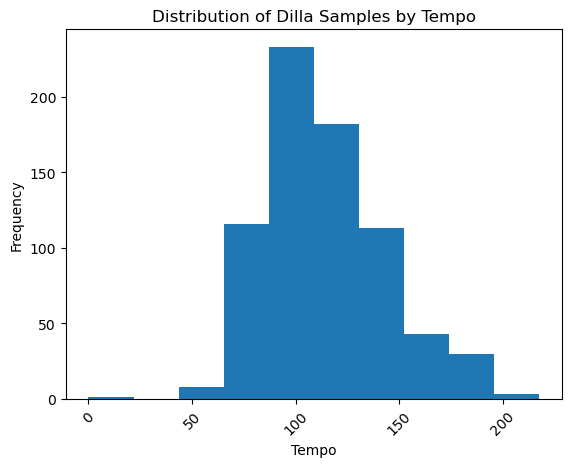

In [18]:
dillaSamples = dillaSamples.dropna(subset=['tempo'])

# Get the min and max of tempo
tempo_min = dillaSamples['tempo'].min()
tempo_max = dillaSamples['tempo'].max()
# Get the mean and median of the year column
tempo_mean = dillaSamples['tempo'].mean()
tempo_median = dillaSamples['tempo'].median()

print("Tempo min:", tempo_min)
print("Tempo max:", tempo_max)
print("Tempo mean:", tempo_mean)
print("Tempo median:", tempo_median)

# Create the histogram
plt.hist(dillaSamples['tempo'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Tempo')
plt.xlabel('Tempo')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

Again, the distribution is unimodal and symmetric around the mean. Most samples he chose had a tempo around the mean of 114. This makes sense as most producers have great time feel and tend to favor certain tempos over others, especially when sampling. Rarely does Dilla sample out of the range of the peak.

Acousticness min: 1.57e-06
Acousticness max: 0.996
Acousticness mean: 0.41634370578875174
Acousticness median: 0.342


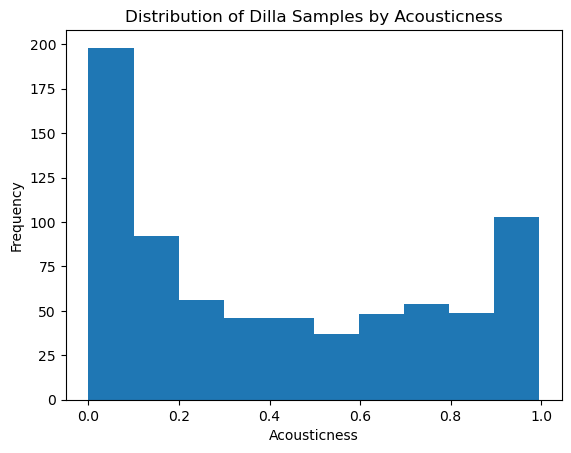

In [19]:
# Drop rows with missing values in the specified columns
dillaSamples = dillaSamples.dropna(subset=['acousticness'])

# Get the min and max of acousticness
acousticness_min = dillaSamples['acousticness'].min()
acousticness_max = dillaSamples['acousticness'].max()
# Get the mean and median of the acousticness column
acousticness_mean = dillaSamples['acousticness'].mean()
acousticness_median = dillaSamples['acousticness'].median()

print("Acousticness min:", acousticness_min)
print("Acousticness max:", acousticness_max)
print("Acousticness mean:", acousticness_mean)
print("Acousticness median:", acousticness_median)

# Create the histogram
plt.hist(dillaSamples['acousticness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Acousticness')
plt.xlabel('Acousticness')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

Here, we start to see variation, with two tails on either end of acousticness. It appears as though most values are either zero or one. This makes me question the reliability of this feature as Spotify could be defaulting to zero for songs it does not have reliable acousticness data for. I will consider this feature because of the wide range, but I will be weary.

Distribution of samples for danceability

Danceability min: 0.0
Danceability max: 0.988
Danceability mean: 0.5614672153635117
Danceability median: 0.563


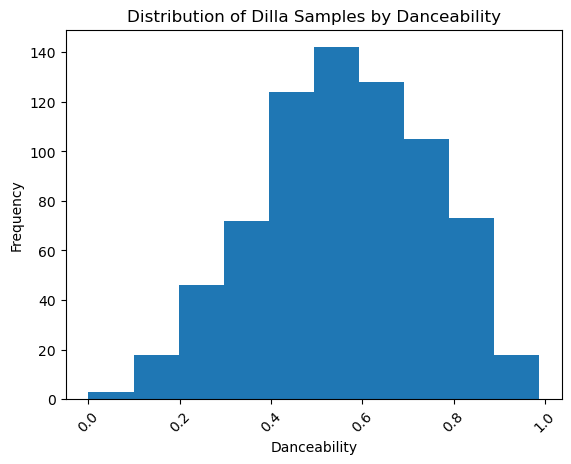

In [20]:
dillaSamples = dillaSamples.dropna(subset=['danceability'])

# Get the min and max of danceability
danceability_min = dillaSamples['danceability'].min()
danceability_max = dillaSamples['danceability'].max()
# Get the mean and median of the danceability column
danceability_mean = dillaSamples['danceability'].mean()
danceability_median = dillaSamples['danceability'].median()

print("Danceability min:", danceability_min)
print("Danceability max:", danceability_max)
print("Danceability mean:", danceability_mean)
print("Danceability median:", danceability_median)

# Create the histogram
plt.hist(dillaSamples['danceability'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Danceability')
plt.xlabel('Danceability')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

The distribution is unimodal and symmetric around the mean. However, there is greater spread compared to other unimodal distributions. The mean is 0.56 which matches the visual. Again, because the way Spotify determining this value is a black box to me, I hope naturally the default is not 0.5, so I will be skeptical but still consider.

Distribution of samples for energy

Energy min: 0.0015
Energy max: 0.991
Energy mean: 0.5000818518518518
Energy median: 0.494


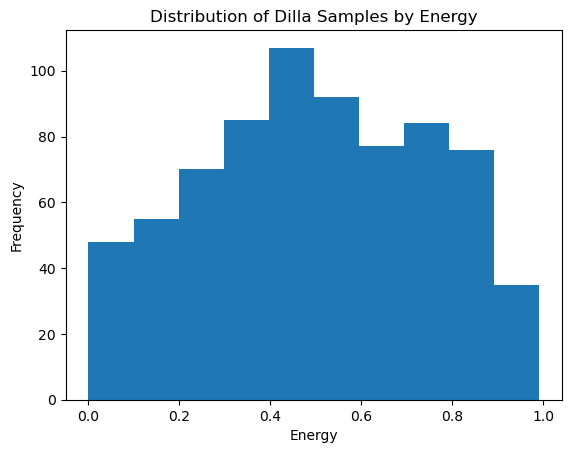

In [21]:
dillaSamples = dillaSamples.dropna(subset=['energy'])

# Get the min and max of energy
energy_min = dillaSamples['energy'].min()
energy_max = dillaSamples['energy'].max()
# Get the mean and median of the energy column
energy_mean = dillaSamples['energy'].mean()
energy_median = dillaSamples['energy'].median()

print("Energy min:", energy_min)
print("Energy max:", energy_max)
print("Energy mean:", energy_mean)
print("Energy median:", energy_median)

# Create the histogram
plt.hist(dillaSamples['energy'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Energy')
plt.xlabel('Energy')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

The distribution is multimodal, but slightly symmetric. There is good variation indicating no default values. This is a good feature to test on.

Distribution of samples for instrumentalness

Instrumentalness min: 0.0
Instrumentalness max: 0.993
Instrumentalness mean: 0.26025561296296296
Instrumentalness median: 0.0081


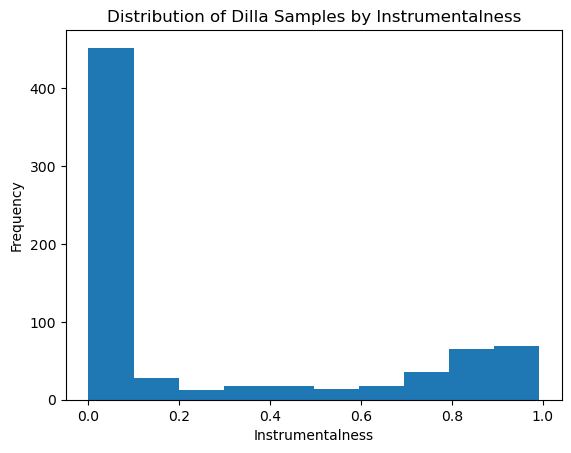

In [22]:
dillaSamples = dillaSamples.dropna(subset=['instrumentalness'])

# Get the min and max of instrumentalness
instrumentalness_min = dillaSamples['instrumentalness'].min()
instrumentalness_max = dillaSamples['instrumentalness'].max()
# Get the mean and median of the instrumentalness column
instrumentalness_mean = dillaSamples['instrumentalness'].mean()
instrumentalness_median = dillaSamples['instrumentalness'].median()

print("Instrumentalness min:", instrumentalness_min)
print("Instrumentalness max:", instrumentalness_max)
print("Instrumentalness mean:", instrumentalness_mean)
print("Instrumentalness median:", instrumentalness_median)

# Create the histogram
plt.hist(dillaSamples['instrumentalness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Instrumentalness')
plt.xlabel('Instrumentalness')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

Most of these values appear to be the default value zero so I will not consider this.

Distribution of samples for liveness

Liveness min: 0.0277
Liveness max: 0.986
Liveness mean: 0.1882496570644719
Liveness median: 0.117


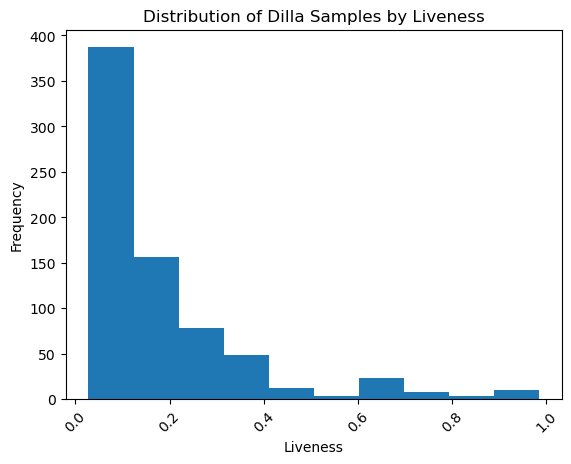

In [23]:
dillaSamples = dillaSamples.dropna(subset=['liveness'])

# Get the min and max of liveness
liveness_min = dillaSamples['liveness'].min()
liveness_max = dillaSamples['liveness'].max()
# Get the mean and median of the liveness column
liveness_mean = dillaSamples['liveness'].mean()
liveness_median = dillaSamples['liveness'].median()

print("Liveness min:", liveness_min)
print("Liveness max:", liveness_max)
print("Liveness mean:", liveness_mean)
print("Liveness median:", liveness_median)

# Create the histogram
plt.hist(dillaSamples['liveness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Liveness')
plt.xlabel('Liveness')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()

Most of these values appear to be the default value zero so I will not consider this.

Distribution of samples for loudness

Loudness min: -41.096
Loudness max: -2.418
Loudness mean: -12.117599451303155
Loudness median: -11.165


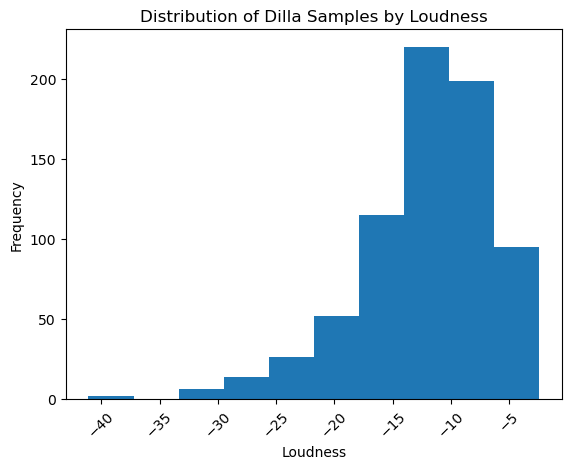

In [24]:
# Drop rows with missing values in the 'loudness' column
dillaSamples = dillaSamples.dropna(subset=['loudness'])

# Get the min and max of loudness
loudness_min = dillaSamples['loudness'].min()
loudness_max = dillaSamples['loudness'].max()
# Get the mean and median of the loudness column
loudness_mean = dillaSamples['loudness'].mean()
loudness_median = dillaSamples['loudness'].median()

print("Loudness min:", loudness_min)
print("Loudness max:", loudness_max)
print("Loudness mean:", loudness_mean)
print("Loudness median:", loudness_median)

# Create the histogram
plt.hist(dillaSamples['loudness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Loudness')
plt.xlabel('Loudness')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


The distribution is unimodal with a rightward skew towards more loud. This feature is robust enough to test further.

Distribution of samples for mode

Mode min: 0.0
Mode max: 1.0
Mode mean: 0.5692729766803841
Mode median: 1.0


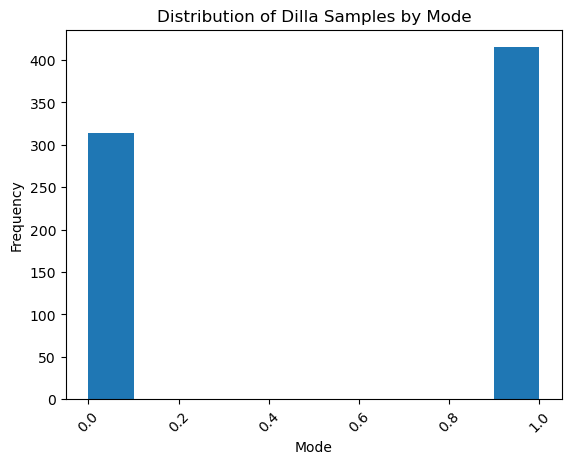

In [25]:
# Get the min and max of mode
mode_min = dillaSamples['mode'].min()
mode_max = dillaSamples['mode'].max()
# Get the mean and median of the mode column
mode_mean = dillaSamples['mode'].mean()
mode_median = dillaSamples['mode'].median()

print("Mode min:", mode_min)
print("Mode max:", mode_max)
print("Mode mean:", mode_mean)
print("Mode median:", mode_median)

# Create the histogram
plt.hist(dillaSamples['mode'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Mode')
plt.xlabel('Mode')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


As the values are either 0 or 1, I will not be considering this feature.

Distribution of samples for speechiness

Speechiness min: 0.0
Speechiness max: 0.946
Speechiness mean: 0.09003237311385459
Speechiness median: 0.0467


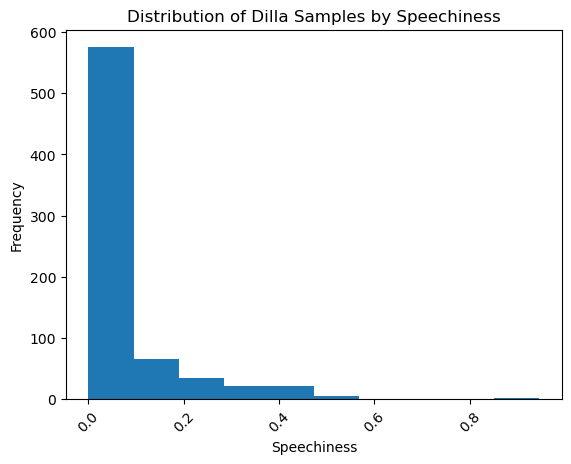

In [26]:
# Drop rows with missing values for speechiness
dillaSamples = dillaSamples.dropna(subset=['speechiness'])

# Get the min and max of speechiness
speechiness_min = dillaSamples['speechiness'].min()
speechiness_max = dillaSamples['speechiness'].max()
# Get the mean and median of the speechiness column
speechiness_mean = dillaSamples['speechiness'].mean()
speechiness_median = dillaSamples['speechiness'].median()

print("Speechiness min:", speechiness_min)
print("Speechiness max:", speechiness_max)
print("Speechiness mean:", speechiness_mean)
print("Speechiness median:", speechiness_median)

# Create the histogram
plt.hist(dillaSamples['speechiness'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Speechiness')
plt.xlabel('Speechiness')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


Most of these values appear to be the default value zero so I will not consider this.

Distribution of samples for valence

Valence min: 0.0
Valence max: 0.979
Valence mean: 0.5185567901234568
Valence median: 0.547


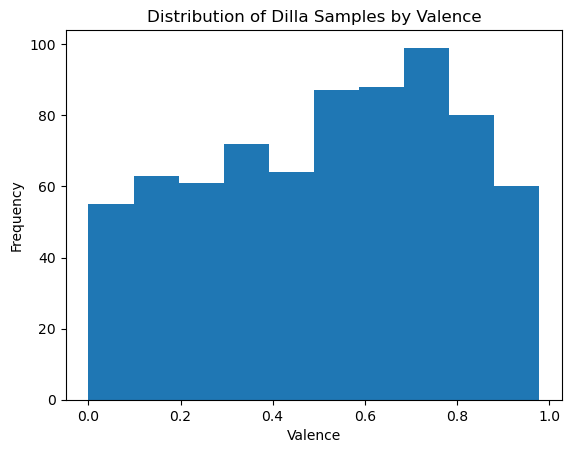

In [27]:
# Drop any rows with missing values for valence
dillaSamples = dillaSamples.dropna(subset=['valence'])

# Get the min and max of valence
valence_min = dillaSamples['valence'].min()
valence_max = dillaSamples['valence'].max()

# Get the mean and median of valence
valence_mean = dillaSamples['valence'].mean()
valence_median = dillaSamples['valence'].median()

print("Valence min:", valence_min)
print("Valence max:", valence_max)
print("Valence mean:", valence_mean)
print("Valence median:", valence_median)

# Create the histogram
plt.hist(dillaSamples['valence'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Valence')
plt.xlabel('Valence')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


The data is skewed to the right and is unimodal with a lot of variation, so I will consider this feature. There appears to be no default value.

Distribution of samples for song popularity

Song popularity min: 0.0
Song popularity max: 87.0
Song popularity mean: 39.249657064471876
Song popularity median: 41.0


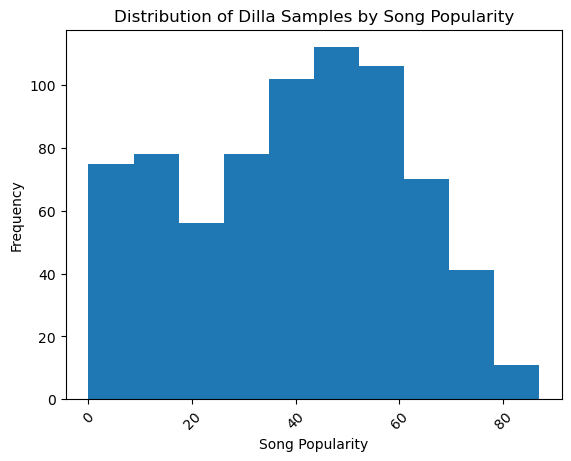

In [28]:
dillaSamples = dillaSamples.dropna(subset=['song_popularity'])

# Get the min and max of song_popularity
song_popularity_min = dillaSamples['song_popularity'].min()
song_popularity_max = dillaSamples['song_popularity'].max()
# Get the mean and median of the song_popularity column
song_popularity_mean = dillaSamples['song_popularity'].mean()
song_popularity_median = dillaSamples['song_popularity'].median()

print("Song popularity min:", song_popularity_min)
print("Song popularity max:", song_popularity_max)
print("Song popularity mean:", song_popularity_mean)
print("Song popularity median:", song_popularity_median)

# Create the histogram
plt.hist(dillaSamples['song_popularity'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Song Popularity')
plt.xlabel('Song Popularity')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


The distribution is bimodal with more of a tail on the left side. This matches the mean being 40, which is more left-skewed. This is a feature I will be paying attention to later.

Distribution of samples by key

Key min: 0.0
Key max: 11.0
Key mean: 5.50480109739369
Key median: 5.0


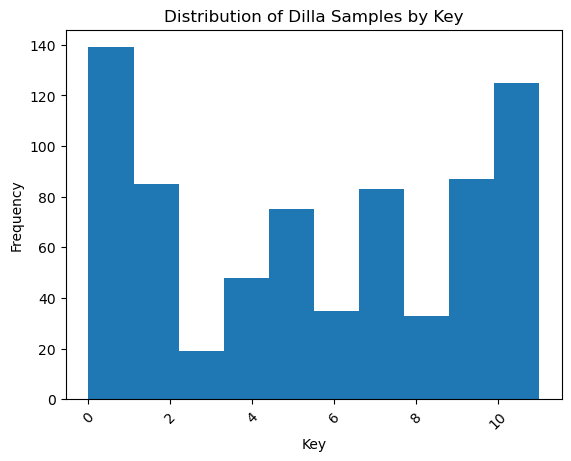

In [29]:
# Drop rows with missing values for key
dillaSamples = dillaSamples.dropna(subset=['key'])

# Get the min and max of key
key_min = dillaSamples['key'].min()
key_max = dillaSamples['key'].max()
# Get the mean and median of the key column
key_mean = dillaSamples['key'].mean()
key_median = dillaSamples['key'].median()

print("Key min:", key_min)
print("Key max:", key_max)
print("Key mean:", key_mean)
print("Key median:", key_median)

# Create the histogram
plt.hist(dillaSamples['key'])

# Set the title and axis labels
plt.title('Distribution of Dilla Samples by Key')
plt.xlabel('Key')
plt.ylabel('Frequency')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the histogram
plt.show()


This distribution is multimodal with tails on both sides. There is a lot of variability but because the key is not a major determinant of a sample selection, I will not be considering this feature.

Distribution of Artists

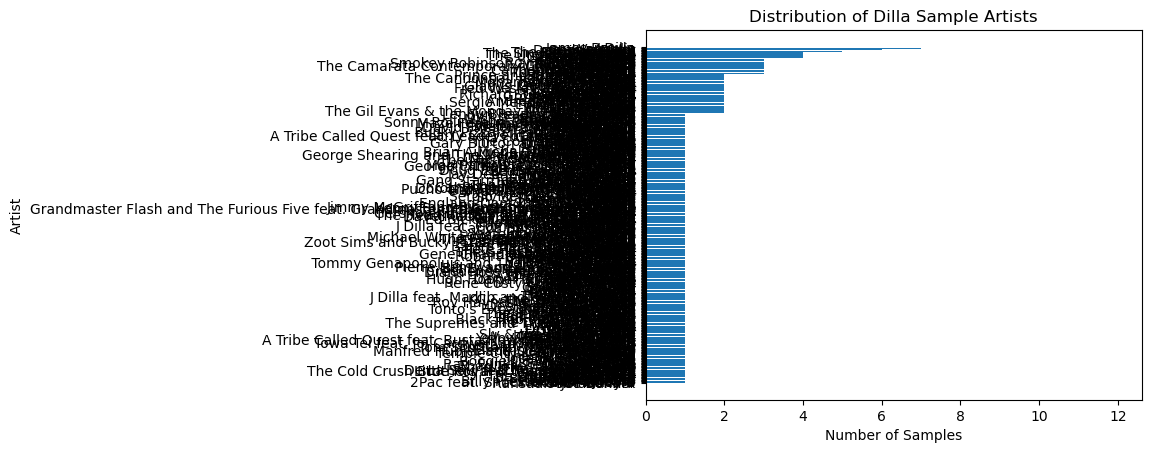

In [30]:
# Split the artists column on commas and explode to create new row for each artist
artist_counts = dillaSamples['artists'].str.split(',', expand=True).stack().reset_index(drop=True)

# Count the frequency of each artist
artist_counts = artist_counts.value_counts()

# Create the bar plot
plt.barh(artist_counts.index, artist_counts.values)

# Set the title and axis labels
plt.title('Distribution of Dilla Sample Artists')
plt.xlabel('Number of Samples')
plt.ylabel('Artist')

# Invert the y-axis to show most frequent artists at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()


With all artists, the distribution looks very messy. As you can see at the bottom, most artists were only sampled once. Let's only look at artists sampled more than twice.

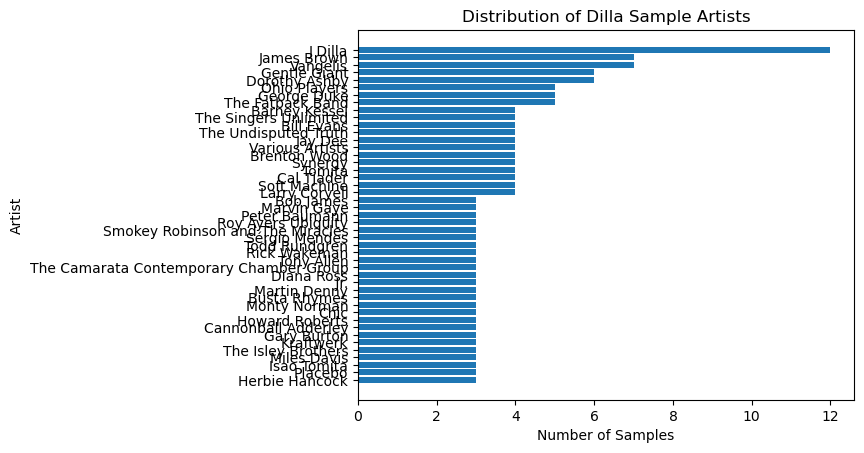

In [31]:
# Split the artists column on commas and explode to create new row for each artist
artist_counts = dillaSamples['artists'].str.split(',', expand=True).stack().reset_index(drop=True)

# Count the frequency of each artist
artist_counts = artist_counts.value_counts()

# Keep only the artists that were sampled more than once
artist_counts = artist_counts[artist_counts > 2]

# Create the bar plot
plt.barh(artist_counts.index, artist_counts.values)

# Set the title and axis labels
plt.title('Distribution of Dilla Sample Artists')
plt.xlabel('Number of Samples')
plt.ylabel('Artist')

# Invert the y-axis to show most frequent artists at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()


This is more readable.

Top 10 artists sampled by Dilla in the dataset.

In [32]:
top_artists = dillaSamples['artists'].value_counts().head(20)
print(top_artists)

J Dilla                  12
James Brown               7
Vangelis                  7
Gentle Giant              6
Dorothy Ashby             6
The Fatback Band          5
Ohio Players              5
George Duke               5
Various Artists           4
Barney Kessel             4
Brenton Wood              4
Cal Tjader                4
Jay Dee                   4
Soft Machine              4
Synergy                   4
Tomita                    4
Larry Coryell             4
Bill Evans                4
The Singers Unlimited     4
The Undisputed Truth      4
Name: artists, dtype: int64


As a list, we can see a lot of big names in soul, funk, motown, etc. It is interesting that Dilla sampled his own music the most.

Top 10 most popular songs on Spotify that Dilla sampled.

In [34]:
top_popularity = dillaSamples.groupby(['song_name', 'song_popularity', 'artists']).size().reset_index(name='count').sort_values(by='song_popularity', ascending=False)
top_popularity = top_popularity.head(10)
top_popularity = top_popularity.drop(columns=['count'])

print(top_popularity)

                                        song_name  song_popularity  \
387                           Middle of the Night             87.0   
713                              You Belong to Me             84.0   
437                                     Old Laces             83.0   
26                              Ain't No Sunshine             82.0   
289  Is This What Feeling Gets? (Dorothy's Theme)             81.0   
403                        More Than a Little Bit             80.0   
703                   Women Don't Want to Love Me             80.0   
468                        People You Can't Trust             80.0   
417                         Never Gonna Come Down             80.0   
485             Put Your Love (In My Tender Care)             80.0   

                            artists  
387                   Lalo Schifrin  
713             The Doobie Brothers  
437                   Lalo Schifrin  
26                   Willis Jackson  
289                 Various Artists  
4

Obviously, there is no relation between the song popularity on Spotify and if Dilla picked the song based on it's popularity, however, it is interesting to see which were the least rare samples he used. There must have been some undeniable breaks in these songs.

To start our analysis of these features in relation to each other, we generated a heatmap to explore the correlations between all variables. This heatmap provides insights into the patterns and relationships that exist within the dataset.

The matrix displayed below represents the heatmap, illustrating the correlations between variables in the entire dataset. Darker boxes indicate high correlations, while lighter cells indicate weaker correlations.

As our goal is to predict the similar songs, we will particularly focus on variables that exhibit high correlation values.

/var/folders/tq/m0x10dfj1nl_sr651fbj7t7r0000gp/T/ipykernel_6705/730728243.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dillaSamples.corr()


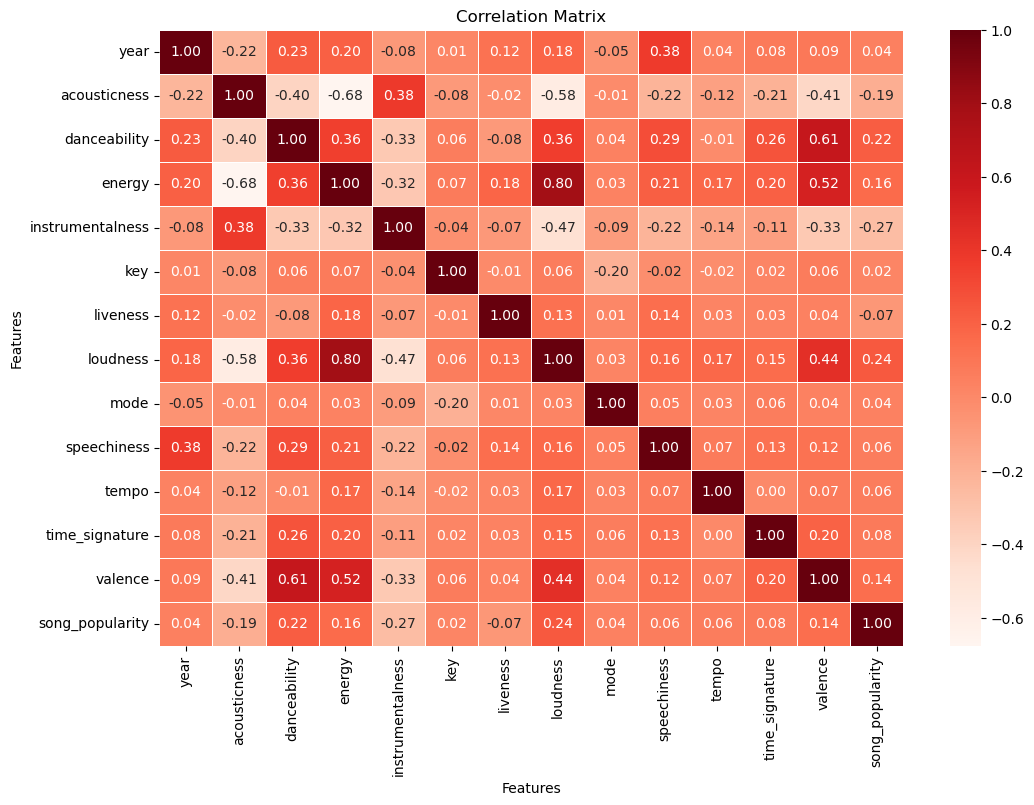

In [35]:
correlation_matrix = dillaSamples.corr()

# Generate a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

Below are correlation values for selected targets.

In [135]:
target = abs(correlation_matrix["year"])
features = target[target>0.2]
features.sort_values()

energy          0.204632
acousticness    0.224768
danceability    0.227752
speechiness     0.377467
year            1.000000
Name: year, dtype: float64

Correlation values too low.

In [136]:
target = abs(correlation_matrix["tempo"])
features = target[target>0.2]
features.sort_values()

tempo    1.0
Name: tempo, dtype: float64

Correlation values too low.

In [137]:
target = abs(correlation_matrix["song_popularity"])
features = target[target>0.2]
features.sort_values()

danceability        0.218198
loudness            0.240447
instrumentalness    0.265573
song_popularity     1.000000
Name: song_popularity, dtype: float64

Correlation values too low.

In [138]:
target = abs(correlation_matrix["energy"])
features = target[target>0.2]
features.sort_values()

time_signature      0.202779
year                0.204632
speechiness         0.210215
instrumentalness    0.324140
danceability        0.355293
valence             0.523083
acousticness        0.676151
loudness            0.796685
energy              1.000000
Name: energy, dtype: float64

Should consider energy as a target due to high correlation values.

In [139]:
target = abs(correlation_matrix["danceability"])
features = target[target>0.2]
features.sort_values()

song_popularity     0.218198
year                0.227752
time_signature      0.262424
speechiness         0.288449
instrumentalness    0.332843
energy              0.355293
loudness            0.360450
acousticness        0.399004
valence             0.607965
danceability        1.000000
Name: danceability, dtype: float64

Should consider danceability as a target due to high correlation values.

In [140]:
target = abs(correlation_matrix["year"])
features = target[target>0.2]
features.sort_values()

instrumentalness    0.335000
acousticness        0.408463
loudness            0.442925
energy              0.523083
danceability        0.607965
valence             1.000000
Name: valence, dtype: float64

Should consider year as a target due to high correlation values.

# Machine Learning: Predicting features

## Training Energy Model using Random Forest

Building on the previous results, we noticed strong correlation values between the target feature 'energy' and the predictor variables: loudness, acousticness, valence, and danceability. This pattern indicates that these variables might play a crucial role in determining the energy level of a music sample.

In light of this, a decision was made to employ a Random Forest Regressor model for our predictive task. Random Forest, an ensemble learning method, constructs numerous decision trees during training and outputs the mean prediction of the individual trees for regression tasks. This method is particularly advantageous because it can handle a mix of variables, is resistant to overfitting, and is capable of capturing complex, non-linear relationships among variables, which makes it suitable for our case given the strong correlations observed.

The goal is to leverage this model to generalize the energy level of unknown music samples using the training features identified. By focusing on the features with the highest correlation values, we are concentrating on the most impactful variables, which should lead to more precise and reliable predictions.

In [144]:
dillaSamples = pd.read_csv('dillaSamples.csv')

dillaSamples = dillaSamples.dropna()

In [153]:
sample_attributes = dillaSamples[['loudness', 'acousticness', 'valence', 'danceability']]
energy_targets = np.array(dillaSamples['energy'])
attribute_list = list(sample_attributes.columns)
attribute_array = np.array(sample_attributes)
train_attr, test_attr, train_energy, test_energy = train_test_split(attribute_array, energy_targets, test_size = 0.25, random_state = 50)

print('Shape of Training Attributes:', train_attr.shape)
print('Shape of Training Energy Targets:', train_energy.shape)
print('Shape of Testing Attributes:', test_attr.shape)
print('Shape of Testing Energy Targets:', test_energy.shape)

Shape of Training Attributes: (487, 4)
Shape of Training Energy Targets: (487,)
Shape of Testing Attributes: (163, 4)
Shape of Testing Energy Targets: (163,)


In [154]:
# Create a Random Forest Regressor object
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model
rf.fit(train_attr, train_energy)

# predict the labels for new data
energy_predictions = rf.predict(test_attr)

mse = mean_squared_error(test_energy, energy_predictions)

# compute r2 score
r2 = r2_score(test_energy, energy_predictions)

print('Mean Squared Error for Energy:', mse)
print('R2 Score:', r2)

Mean Squared Error for Energy: 0.013018044641490518
R2 Score: 0.7967793280132838


We are getting an R2 Score of 0.79 which is decent considering there are not many correlations within our data. Below I will graph the importance of each feature to check the feature dependence.

Importance of loudness: 0.67
Importance of acousticness: 0.19
Importance of valence: 0.08
Importance of danceability: 0.05


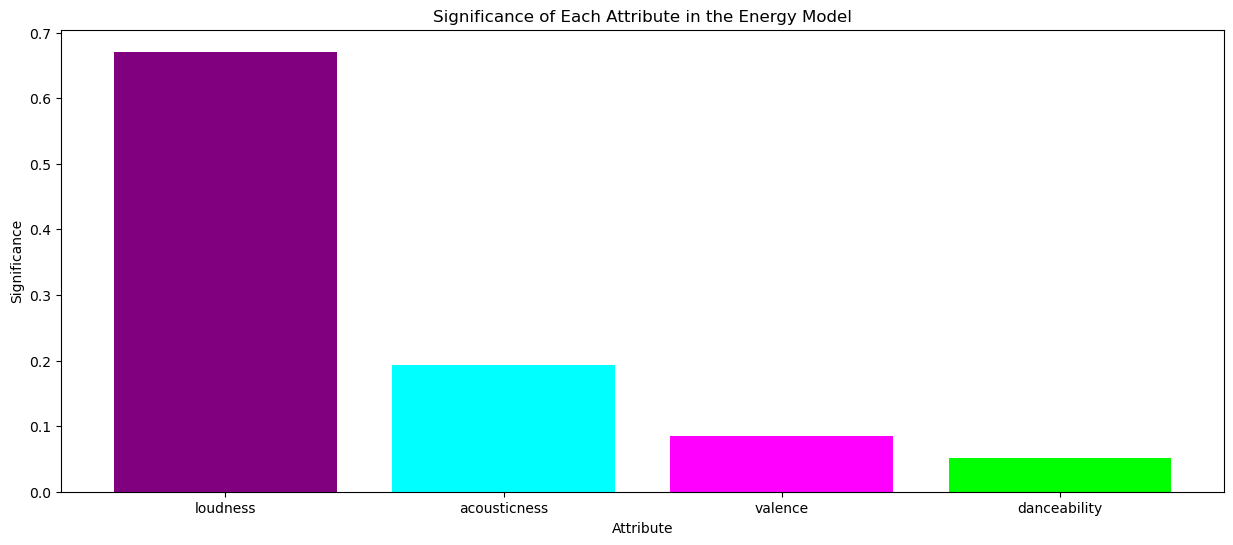

In [160]:
# Extract feature importances
energy_model_importances = list(rf.feature_importances_)

# Pair each feature with its importance
attribute_importance_pairs = [(attribute, round(importance_val, 2)) 
                              for attribute, importance_val in zip(attribute_list, energy_model_importances)]

for pair in attribute_importance_pairs:
  print(f"Importance of {pair[0]}: {pair[1]}")

bar_colors = ['purple', 'cyan', 'magenta', 'lime', 'gold']

# Generate the bar chart
plt.bar(attribute_list, energy_model_importances, color=bar_colors)
plt.ylabel('Significance') 
plt.xlabel('Attribute') 
plt.title('Significance of Each Attribute in the Energy Model')
plt.gcf().set_size_inches((15, 6))
plt.show()


Here we can see that loudness has the greatest significance, while danceability has the least. Let's remove danceability as a feature and retrain the model.

In [162]:
sample_attributes = dillaSamples[['loudness', 'acousticness', 'valence']]
energy_targets = np.array(dillaSamples['energy'])
attribute_list = list(sample_attributes.columns)
attribute_array = np.array(sample_attributes)
train_attr, test_attr, train_energy, test_energy = train_test_split(attribute_array, energy_targets, test_size = 0.25, random_state = 50)

# Create a Random Forest Regressor object
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model
rf.fit(train_attr, train_energy)

# predict the labels for new data
energy_predictions = rf.predict(test_attr)

mse = mean_squared_error(test_energy, energy_predictions)

# compute r2 score
r2 = r2_score(test_energy, energy_predictions)

print('Mean Squared Error for Energy:', mse)
print('R2 Score:', r2)

Mean Squared Error for Energy: 0.013452370907327007
R2 Score: 0.7899991948953299


Our R2 score got worse meaning although the danceability feature was not as significant as the rest of the features, it still helped the model better generalize, so it should be kept to train the model and improve it's accuracy.

## Clustering

We want to see how our data naturally relates to itself, and consequently how it clusters. We decide below to use hierarchical clustering over K-Means clustering as we can use a dendrogram to help us decide on the number of clusters rather than specifiying exactly how many beforehand. Also, the data is not clustered to specific sizes and is instead handled with different shapes, allowing for better generaliztion.

The following steps are taken below:
Preprocessing: The 'genres' column is split by commas and converted to a binary format using one-hot encoding.

Standardization: The selected features are standardized (scaled) to have a mean of 0 and a standard deviation of 1. Standardizing the features is a common practice in machine learning to make sure that all features have the same scale.

Principal Component Analysis (PCA): PCA is used to reduce the dimensionality of the data for visualization purposes. The scaled data is transformed into 2 principal components.

DBSCAN Clustering: DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that groups together points that are packed closely together (points with many nearby neighbors).

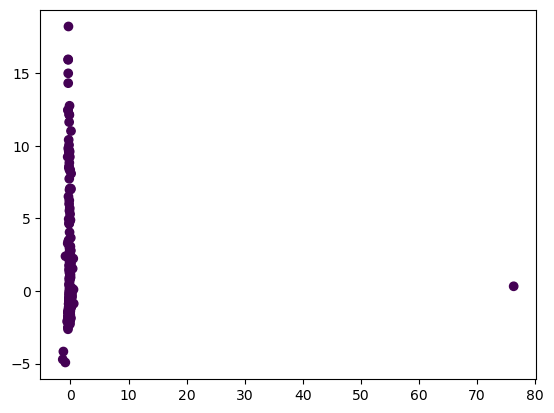

In [74]:
# Load your data
dillaSamples = pd.read_csv('dillaSamples.csv')

# Convert 'genres' column to string type and replace 'nan' with ''
dillaSamples['genres'] = dillaSamples['genres'].astype(str).replace('nan', '')

dillaSamples = dillaSamples.dropna()

# One-hot encoding of categorical genre values
mlb = MultiLabelBinarizer()
dillaSamples = dillaSamples.join(pd.DataFrame(mlb.fit_transform(dillaSamples.pop('genres').str.split(',')),
                          columns=mlb.classes_,
                          index=dillaSamples.index))


# Standardize features to have mean=0 and variance=1
features = ['acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence', 'song_popularity'] + list(mlb.classes_)
scaler = StandardScaler()
dillaSamples_scaled = scaler.fit_transform(dillaSamples[features])

# Perform PCA for visualization
pca = PCA(n_components=2)
dillaSamples_pca = pca.fit_transform(dillaSamples_scaled)

# Perform DBSCAN
db = DBSCAN(eps=0.3, min_samples=2)
db.fit(dillaSamples_scaled)

# Plot the clusters
plt.scatter(dillaSamples_pca[:, 0], dillaSamples_pca[:, 1], c=db.labels_)
plt.show()

The DBSCAN  did not result in distinct clusters, instead most of it moved to the left indicating that most of the values were considered noise (-1)

Let's try hierarchical clustring instead. Below are the following steps we take:

Hierarchical Clustering: This algorithm starts by treating each data point as a single cluster and then successively merges the closest pairs of clusters until only one cluster (or a specified number of clusters) is left.

Dendrogram Plotting: A dendrogram is a tree-like diagram that displays the sequences of merges or splits. The dendrogram helps to decide the number of clusters that can best fit the data.

Assigning Cluster Labels: After deciding on the optimal number of clusters, hierarchical clustering is applied again, this time with a specified number of clusters. The resulting cluster labels are added to the original DataFrame.

Displaying Top Genres for Each Cluster: Finally, the top 5 genres for each cluster are displayed.

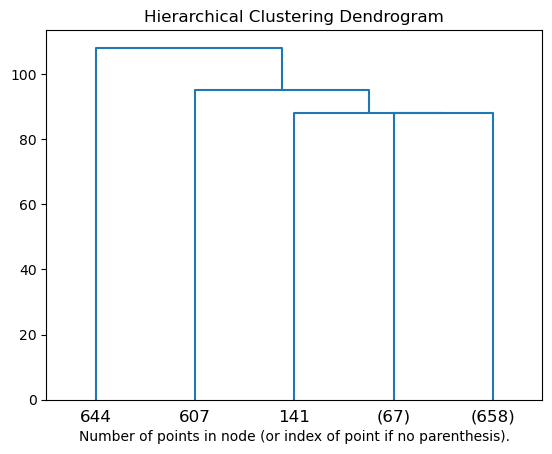

In [168]:
# Perform hierarchical clustering
hclust = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage='ward')
hclust.fit(dillaSamples_scaled)

# Function to plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Plot the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hclust, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [78]:
n_clusters = 5  # Replace with your chosen number
hclust = AgglomerativeClustering(n_clusters=n_clusters)
hclust.fit(dillaSamples_scaled)

# Add cluster labels to original DataFrame
dillaSamples['cluster'] = hclust.labels_

# Get top 5 genres for each cluster
for cluster in range(n_clusters):
    print(f'Cluster {cluster}:')
    print(dillaSamples[dillaSamples['cluster'] == cluster][mlb.classes_].mean().nlargest(5))

Cluster 0:
soul            0.147416
                0.118541
funk            0.109422
classic soul    0.094225
motown          0.082067
dtype: float64
Cluster 1:
classic rock    0.567164
album rock      0.432836
rock            0.388060
soft rock       0.358209
mellow gold     0.343284
dtype: float64
Cluster 2:
british experimental    1.0
british industrial      1.0
experimental            1.0
experimental rock       1.0
industrial              1.0
dtype: float64
Cluster 3:
australian alternative rock    1.0
australian dance               1.0
collage pop                    1.0
electronica                    1.0
indietronica                   1.0
dtype: float64
Cluster 4:
australian metalcore    1.0
blackened deathcore     1.0
brutal deathcore        1.0
deathcore               1.0
melodic deathcore       1.0
dtype: float64


We see that even though we used the same sample attributes for the algorithm, we obtained far better clustering using hierarchical clustering. In each cluster, similar genres have been grouped together such as all the types of rock in Cluster 1. I believe we are seeing far better results compared to DBSCAN because most values were being treated as noise, so it was not being properly considered.

## Conclusion

Having delved deeply into the 'dillaSamples' dataset and gained considerable insight, we will now summarize our findings, outline the process of building our machine learning model, and share the results of this endeavor.

Through our exploration and modeling, we have confirmed that predicting the energy level of a song with a high degree of accuracy is indeed feasible. Several key features play crucial roles in determining this, including 'loudness', 'acousticness', 'valence', and 'danceability'. All of these attributes share a correlation with the energy level of a song, thereby strongly influencing it.

The correlation scores of these various features offered by our models allowed us to further probe the relationship these attributes share with the energy level of a song. For instance, we developed a more nuanced understanding of how 'loudness' and 'danceability' relates to the energy level of a song.

Ultimately, we applied supervised learning to construct a RandomForest model to predict the energy levels of songs. To enhance the precision of our predictions, we evaluted each feature, achieving a prediction accuracy of 79%—a result we are quite satisfied with. We also experimented with the removal of some important features from our prediction model to gauge their impact on the results.

In addition to our predictive modeling, an exciting part of our exploration involved the successful application of hierarchical clustering to group similar genres together. Hierarchical clustering allowed us to delve into the inherent structure of our dataset and uncover nuanced relationships between various genres based on their musical characteristics such as 'loudness', 'acousticness', 'valence', and 'danceability'.

Our use of dendrograms also facilitated visualization of the clustering process, helping to highlight how each genre was grouped iteratively based on musical similarity. This not only enhanced our understanding of the genre landscape but also presented an intuitive way to decide on the number of clusters.

In conclusion, we are extremely pleased with the outcomes of our project and prediction model. It provided an opportunity to delve into an interesting dataset, gain insights into the world of music, and hone our skills in creating, training, and predicting with machine learning models. However, this project merely scratches the surface, and there is undoubtedly much more that could be learned from this rich dataset.